# **Skin Cancer Image Classification**

In [27]:
from PIL import Image
import pandas as pd
import datetime

import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import array_to_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, BatchNormalization, Dropout, Dense, MaxPool2D
from keras.callbacks import ReduceLROnPlateau

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

**THERE ARE TOTAL OF 7 DIFFERENT KIND OF CLASSES PRESENT HERE WHICH AE TO BE CLASSIFIED**

0: nv - Melanocytic nevi

1: mel - Melanoma

2: bkl - Benign keratosis-like lesions

3: bcc - Basal cell carcinoma

4: akiec - Actinic keratoses and intraepithelial carcinoma / Bowen's disease

5: vasc - Vascular lesions

6: df - Dermatofibroma

<AxesSubplot:>

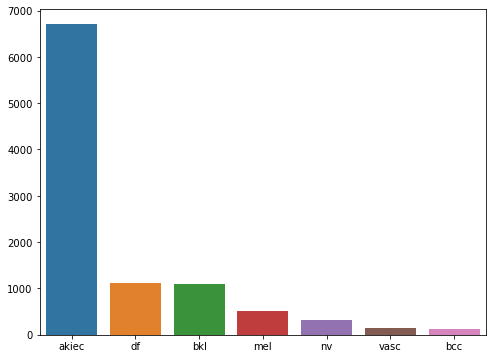

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
raw_data = pd.read_csv('../input/skin-cancer-mnist-ham10000/hmnist_28_28_RGB.csv')
raw_data = raw_data.sample(frac = 1)
data = raw_data.iloc[:,:-1]
labels = raw_data.iloc[:,-1:]

type_cancer = ['akiec','df','bkl','mel','nv','vasc','bcc']
counts = list(labels.value_counts())
plt.figure(figsize = (8,6))
sns.barplot(x = type_cancer, y = counts)

**MANUALLY UPSAMPLING THE CLASS DISTRIBUTIONS FOR PREDICTING THE CORRECT CLASS LABEL**

In [18]:
raw_data = pd.read_csv('../input/skin-cancer-mnist-ham10000/hmnist_28_28_RGB.csv')
raw_data = raw_data.sort_values('label')
raw_data = raw_data.reset_index()

index0 = raw_data[raw_data['label'] == 0].index.values
index1 = raw_data[raw_data['label'] == 1].index.values
index2 = raw_data[raw_data['label'] == 2].index.values
index3 = raw_data[raw_data['label'] == 3].index.values
index5 = raw_data[raw_data['label'] == 5].index.values
index6 = raw_data[raw_data['label'] == 6].index.values

df_index0 = raw_data.iloc[int(min(index0)):int(max(index0)+1)]
df_index1 = raw_data.iloc[int(min(index1)):int(max(index1)+1)]
df_index2 = raw_data.iloc[int(min(index2)):int(max(index2)+1)]
df_index3 = raw_data.iloc[int(min(index3)):int(max(index3)+1)]
df_index5 = raw_data.iloc[int(min(index5)):int(max(index5)+1)]
df_index6 = raw_data.iloc[int(min(index6)):int(max(index6)+1)]


df_index0 = df_index0.append([df_index0]*17, ignore_index = True)
df_index1 = df_index1.append([df_index1]*15, ignore_index = True)
df_index2 = df_index2.append([df_index2]*5, ignore_index = True)
df_index3 = df_index3.append([df_index3]*52, ignore_index = True)
df_index5 = df_index5.append([df_index5]*45, ignore_index = True)
df_index6 = df_index6.append([df_index6]*5, ignore_index = True)

frames = [raw_data, df_index0, df_index1, df_index2, df_index3, df_index5, df_index6]

final_data = pd.concat(frames)
final_data.drop('index', inplace = True, axis = 1)
final_data = final_data.sample(frac = 1)
data = final_data.iloc[:,:-1]
labels = final_data.iloc[:,-1:]

In [20]:
raw_data.iloc[int(min(index2)):int(max(index2)+1)].shape

(1099, 2354)

In [13]:
raw_data.iloc[int(min(index0)):int(max(index0)+1)].shape

(327, 2354)

In [15]:
raw_data[raw_data['label'] == 3].index.values.shape

(115,)

[8738, 7791, 7693, 6705, 6674, 6213, 6210]


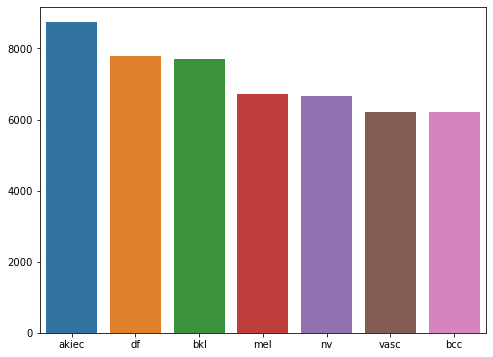

In [24]:
'''
NOW WE CAN SEE THAT THE DISTRIBUTION OF THE CLASSES ARE MORE NORMALIZED THAN BEFORE
AND NOT BIASED FOR ONE SPECIFIC CLASSES
'''

type_cancer = ['akiec','df','bkl','mel','nv','vasc','bcc']
counts = list(labels.value_counts())
plt.figure(figsize = (8,6))
sns.barplot(x = type_cancer, y = counts)
print(list(labels.value_counts()))

**RESHAPING THE DATA TO FEED INTO THE CNN MODEL**

In [25]:
X = np.array(data)
Y = np.array(labels)

# reshaping the data

X = X.reshape(-1,28,28,3)

print("SHAPE OF X IS: ", X.shape)
print("SHAPE OF Y IS: ", Y.shape)

SHAPE OF X IS:  (50024, 28, 28, 3)
SHAPE OF Y IS:  (50024, 1)


**VISUALISING THE PLOTS OF THE IMAGES WHERE EACH OF THE IMAGES ARE LABELED WITH 
THE CORRESPONDING LABELS OF THE IMAGES i.e. WHICH TYPE OF THE CACNCER IT IS**

nv - Melanocytic nevi

mel - Melanoma

bkl - Benign keratosis-like lesions

bcc - Basal cell carcinoma

akiec - Actinic keratoses and intraepithelial carcinoma / Bowen's disease

vasc - Vascular lesions

df - Dermatofibroma

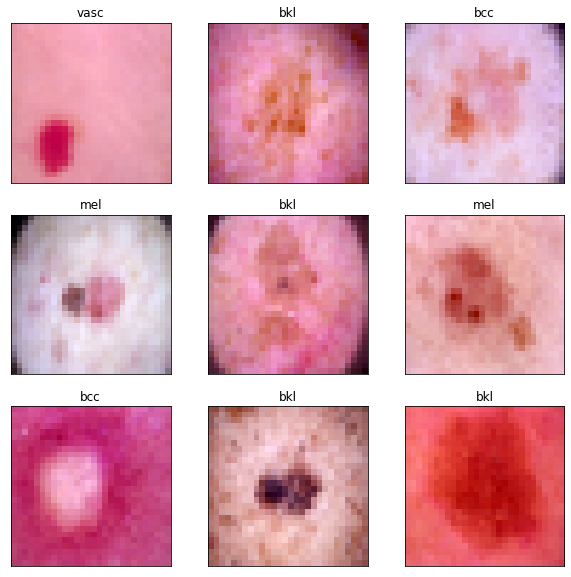

In [30]:
def visualisePlots(X,Y, rows, columns):
    class_dicts = {
        0: 'nv',
        1: 'mel',
        2: 'bkl',
        3: 'bcc',
        4: 'akiec',
        5: 'vasc',
        6: 'df', 
    }
    
    data = []
    target = []

    for i in range(rows*columns):
        data.append(X[i])
        target.append(Y[i])

    width = 10
    height = 10
    fig = plt.figure(figsize=(10,10))
    for i in range(columns*rows):
        temp_img = array_to_img(data[i])
        fig.add_subplot(rows, columns, i+1)
        plt.imshow(temp_img)
        plt.xticks([])
        plt.yticks([])
        plt.title(str(class_dicts[target[i][0]]))
    plt.show()
    
# using the above function

visualisePlots(X,Y, 3,3)

### GETTING THE FEARURES FROM DATA, MAKING THE MODEL, TRAINING THE MODEL

In [31]:
X = (X-np.mean(X))/np.std(X) # Standardizing the data on X
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1) 

train_datagen = ImageDataGenerator(rescale = 1./255,
                                  rotation_range = 10,
                                  width_shift_range = 0.2,
                                  height_shift_range = 0.2,
                                  shear_range = 0.2,
                                  horizontal_flip = True,
                                  vertical_flip = True,
                                  fill_mode = 'nearest')
train_datagen.fit(X_train)

test_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen.fit(X_test)

train_data = train_datagen.flow(X_train, Y_train, batch_size = 64)
test_data = test_datagen.flow(X_test, Y_test, batch_size = 64)

**BUILDING THE MODEL**

In [32]:
model = Sequential()
model.add(Conv2D(16, kernel_size = (3,3), input_shape = (28, 28, 3), activation = 'relu', padding = 'same'))
model.add(Conv2D(32, kernel_size = (3,3), activation = 'relu'))
model.add(MaxPool2D(pool_size = (2,2)))

model.add(Conv2D(32, kernel_size = (3,3), activation = 'relu', padding = 'same'))
model.add(Conv2D(64, kernel_size = (3,3), activation = 'relu'))
model.add(MaxPool2D(pool_size = (2,2), padding = 'same'))

model.add(Conv2D(64, kernel_size = (3,3), activation = 'relu'))
model.add(Conv2D(64, kernel_size = (3,3), activation = 'relu', padding = 'same'))
model.add(MaxPool2D(pool_size = (2,2), padding = 'same'))

model.add(Flatten())

model.add(Dense(64, activation = 'relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(7, activation='softmax'))


learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1)

optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)

model.compile(loss = 'sparse_categorical_crossentropy',
             optimizer = optimizer,
              metrics = ['accuracy'])

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 16)        448       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 26, 26, 32)        4640      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 32)        9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 4, 4, 64)          3

**TRAINING THE MODEL**

In [33]:
history = model.fit(X_train,
                    Y_train,
                    validation_split=0.2,
                    batch_size = 32,
                    epochs = 10,
                    callbacks=[learning_rate_reduction])

Epoch 1/10
1001/1001 [==============================] - 44s 43ms/step - loss: 1.5114 - accuracy: 0.3859 - val_loss: 0.8045 - val_accuracy: 0.6942
Epoch 2/10
1001/1001 [==============================] - 42s 42ms/step - loss: 0.6974 - accuracy: 0.7336 - val_loss: 0.4741 - val_accuracy: 0.8186
Epoch 3/10
1001/1001 [==============================] - 42s 42ms/step - loss: 0.4262 - accuracy: 0.8376 - val_loss: 0.3199 - val_accuracy: 0.8849
Epoch 4/10
1001/1001 [==============================] - 41s 41ms/step - loss: 0.3155 - accuracy: 0.8793 - val_loss: 0.4005 - val_accuracy: 0.8556
Epoch 5/10
1001/1001 [==============================] - 41s 41ms/step - loss: 0.2606 - accuracy: 0.9051 - val_loss: 0.2171 - val_accuracy: 0.9243
Epoch 6/10
1001/1001 [==============================] - 41s 41ms/step - loss: 0.1819 - accuracy: 0.9314 - val_loss: 0.2428 - val_accuracy: 0.9164
Epoch 7/10
1001/1001 [==============================] - 41s 41ms/step - loss: 0.1616 - accuracy: 0.9407 - val_loss: 0.1531 -

**Plotting training and validation curve for the model**

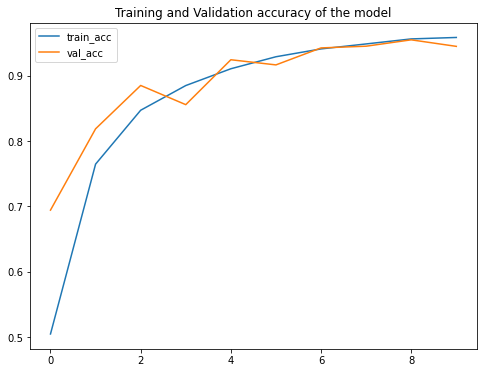

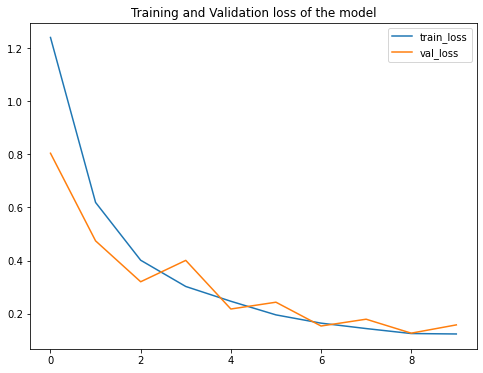

In [34]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.figure(figsize=(8,6))
plt.title("Training and Validation accuracy of the model")
plt.plot(acc, label = 'train_acc')
plt.plot(val_acc, label = 'val_acc')
plt.legend()

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8,6))
plt.title("Training and Validation loss of the model")
plt.plot(loss, label = 'train_loss')
plt.plot(val_loss, label = 'val_loss')
plt.legend()

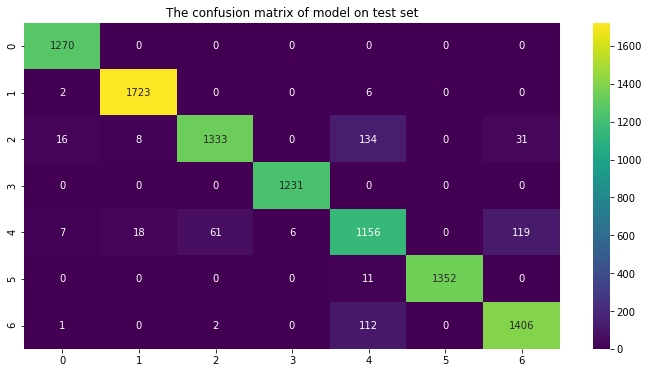

In [40]:
Y_true = np.array(Y_test)

Y_pred = model.predict(X_test)
Y_pred = np.array(list(map(lambda x: np.argmax(x), Y_pred)))

cm1 = confusion_matrix(Y_true, Y_pred)
plt.figure(figsize=(12, 6))
plt.title('The confusion matrix of model on test set')
sns.heatmap(cm1, annot = True, fmt = 'g' ,vmin = 0, cmap = 'viridis')
plt.show()

THE PLOTS TESTING WITH THE MODEL


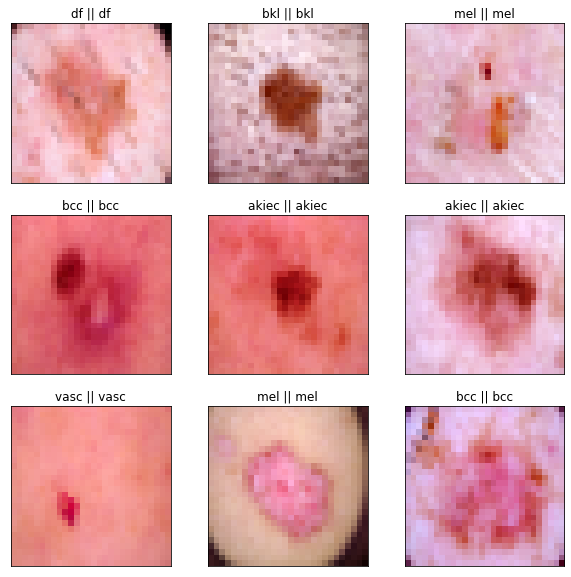

In [36]:
def visualisePlots_test(X,Y, model, rows, columns):
    class_dicts = {
        0: 'nv',
        1: 'mel',
        2: 'bkl',
        3: 'bcc',
        4: 'akiec',
        5: 'vasc',
        6: 'df', 
    }
    
    data = []
    target = []
    
    Y_pred = model.predict(X)
    Y_pred = np.array(list(map(lambda x: np.argmax(x), Y_pred)))

    for i in range(rows*columns):
        data.append(X[i])
        target.append(Y[i])

    width = 10
    height = 10
    fig = plt.figure(figsize=(10,10))
    for i in range(columns*rows):
        temp_img = array_to_img(data[i])
        fig.add_subplot(rows, columns, i+1)
        plt.imshow(temp_img)
        plt.xticks([])
        plt.yticks([])
        plt.title(str(class_dicts[target[i][0]]) + " || " + str(class_dicts[Y_pred[i]]))
    plt.show()
    
# USING THE MODELS AND VISUALISING THEM

print('THE PLOTS TESTING WITH THE MODEL')
visualisePlots_test(X_test,Y_test, model, 3, 3) 

Getting the correct labels after training the model.

**Confusion Matrix**

In [37]:
label_mapping = {
    0: 'nv',
    1: 'mel',
    2: 'bkl',
    3: 'bcc',
    4: 'akiec',
    5: 'vasc',
    6: 'df'
}

classification_report_model = classification_report(Y_true, Y_pred, target_names=label_mapping.values())
print(classification_report_model)

              precision    recall  f1-score   support

          nv       0.98      1.00      0.99      1270
         mel       0.99      1.00      0.99      1731
         bkl       0.95      0.88      0.91      1522
         bcc       1.00      1.00      1.00      1231
       akiec       0.81      0.85      0.83      1367
        vasc       1.00      0.99      1.00      1363
          df       0.90      0.92      0.91      1521

    accuracy                           0.95     10005
   macro avg       0.95      0.95      0.95     10005
weighted avg       0.95      0.95      0.95     10005



**Evaluating the performance on test set**

In [38]:
model_acc_test = model.evaluate(X_test, Y_test, verbose=0)[1]
print("Test Accuracy of model: {:.3f}%".format(model_acc_test * 100))

Test Accuracy of model: 94.663%


**WE ARE GETTING AN ACCURACY OF 94% ON THE TEST DATA WHICH IS PRETTY GOOD.**